In [1]:
from pyhail import common, hdr, hsda, mesh_ppi, hacc, mesh_grid
import numpy as np

import matplotlib.pyplot as pl
import matplotlib.colors as colors

import pyart

In [2]:
#example radar data
filename = 'data/66_20231110_063000.pvol.h5'

#load radar data
radar_unsorted = pyart.aux_io.read_odim_h5(filename, file_field_names=True)

In [3]:
#resort by elevation angle
sweep_sort_idx = np.argsort(radar_unsorted.fixed_angle['data'])
radar = radar_unsorted.extract_sweeps(sweep_sort_idx)

#load the classification field into the radar object sweep from the odimh5 file
empty_radar_field = {'data': np.zeros((radar.nrays, radar.ngates)),
                    'units':'',
                    'long_name': '',
                    'description': '',
                    'comments': ''}
radar.add_field('HCA', empty_radar_field)
for sweep in range(radar.nsweeps):
    hca_meta = common.get_odim_ncar_hca(radar.fixed_angle['data'][sweep], filename,
                                        np.shape(radar.get_field(sweep, 'DBZH')), skip_birdbath=True)
    radar.fields['HCA']['data'][radar.get_slice(sweep)] = hca_meta['data']

#find lowest elevation angle
sweep0_idx = np.argmin(radar.fixed_angle['data'])

#run HDR
radar = hdr.pyart(radar,
                  'DBZH',
                  'ZDR')

#run HSDA
radar = hsda.pyart(radar, 
          'DBZH',
          'ZDR', 
          'RHOHV', 
          'HCA',
          [4000, 5500], 
          [6, 7, 8])

#run MESH PPI
radar = mesh_ppi.pyart(radar,
                    'DBZH',
                    [4000,5500])

#run HACC
radar = hacc.pyart(radar,
                   'DBZH',
                    sweep0_idx, 
                    sweep0_idx,
                    4000, 
                    700)

#grid configuration required for calculating MESH
grid_shape  = (41, 201, 201)
grid_limits = ((0, 20000), (-100000.0, 100000.0), (-100000.0, 100000.0))
grid_roi    = 2000
#run gridding
grid = pyart.map.grid_from_radars(
    radar,
    grid_shape = grid_shape,
    grid_limits = grid_limits,
    weighting_function = 'Barnes',
    gridding_algo = 'map_gates_to_grid',
    roi_func='constant', constant_roi = grid_roi,
    fields=['DBZH'])
#run MESH grid
meshgrid_fields = mesh_grid.main(grid, 'DBZH', [4000,5500])
grid.add_field('mesh', meshgrid_fields['mesh_mh2019_75'], replace_existing=True)

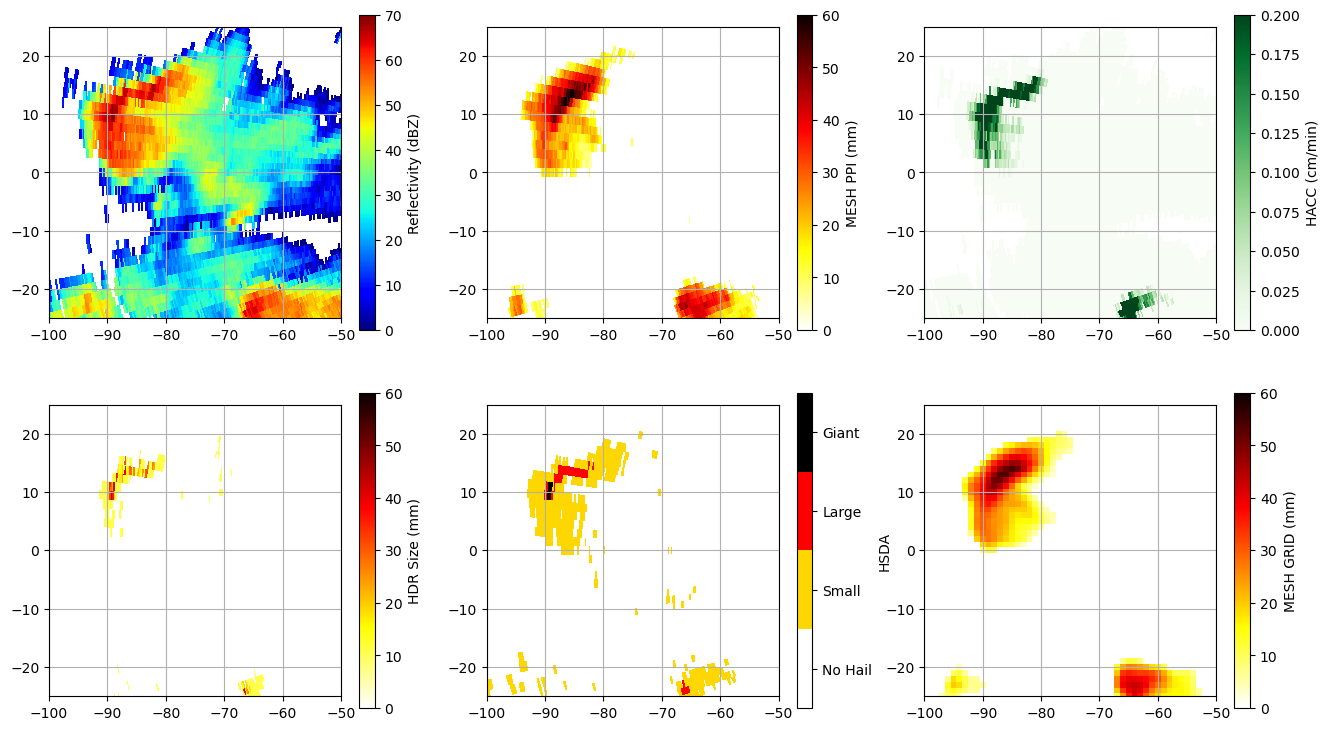

In [4]:
sweep0_x, sweep0_y, _ = radar.get_gate_x_y_z(sweep0_idx)

x_coords = sweep0_x/1000
y_coords = sweep0_y/1000
x_lim = [-100,-50]
y_lim = [-25, 25]

hsda_colors = [
    "White",
    "Gold",
    "Red",
    "Black",
    ]
hsda_cmap = colors.ListedColormap(hsda_colors) 

fig, axs = pl.subplots(nrows=2, ncols=3, figsize=(16, 9))
axs = axs.flatten()

im = axs[0].pcolormesh(x_coords, y_coords, radar.get_field(sweep0_idx, 'DBZH'), cmap='jet', vmin=0, vmax=70)
cbar = fig.colorbar(im, ax=axs[0], label='Reflectivity (dBZ)')

im = axs[1].pcolormesh(x_coords, y_coords, radar.get_field(sweep0_idx, 'mesh'), cmap='hot_r', vmin=0, vmax=60)
cbar = fig.colorbar(im, ax=axs[1], label='MESH PPI (mm)')

im = axs[2].pcolormesh(x_coords, y_coords, radar.get_field(sweep0_idx, 'hacc'), cmap='Greens', vmin=0, vmax=0.2)
cbar = fig.colorbar(im, ax=axs[2], label='HACC (cm/min)')

im = axs[3].pcolormesh(x_coords, y_coords, radar.get_field(sweep0_idx, 'hdr_size'), cmap='hot_r', vmin=0, vmax=60)
cbar = fig.colorbar(im, ax=axs[3], label='HDR Size (mm)')

im = axs[4].pcolormesh(x_coords, y_coords, radar.get_field(sweep0_idx, 'hsda'), cmap=hsda_cmap, vmin=-0.5, vmax=3.5)
cbar = fig.colorbar(im, ax=axs[4], label='HSDA')
cbar.set_ticks([0, 1, 2, 3])
cbar.set_ticklabels(["No Hail", "Small", "Large", "Giant"])

grid_x_coords = grid.point_x['data'][0,:,:]/1000
grid_y_coords = grid.point_y['data'][0,:,:]/1000
im = axs[5].pcolormesh(grid_x_coords, grid_y_coords, grid.fields['mesh']['data'][0,:,:], cmap='hot_r', vmin=0, vmax=60)
cbar = fig.colorbar(im, ax=axs[5], label='MESH GRID (mm)')

for ax in axs:
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.grid()
    ax.set_aspect('equal', 'box')

